In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
import pylab as pl
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
#import sys
#!{sys.executable} -m pip install pmdarima
#import pmdarima as pm
#!{sys.executable} -m pip install tensorflow_probability
#import tensorflow.compat.v2 as tf
#from tensorflow_probability import sts
#import tensorflow_probability as tfp

#from tensorflow_probability import distributions as tfd

#import collections
#tf.enable_v2_behavior()

## Content
- Update on Google Trends model
    - Stationary Test
    - Data 
- Evaluation metrics
    - Rolling training
- Stacking
    


## 1. Update on Google Trends model

### 1.1 Stationarity Test

In milestone 2, the prediction target in google trends model is the listing data it self. However, since it is a time series target, a stationarity test is necessary to suggest whether the target itself or which order difference should be used. We will use unit root (Augmented Dickey-Fuller) test here.

In [2]:
url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df1 = pd.read_csv(dwn_url)

In [3]:
df1['sale_month'] = df1.sale_date.apply(lambda x: str(x)[:-3])
df1['list_month'] = df1.list_date.apply(lambda x: str(x)[:-3])
df_listing = df1.groupby(["list_month"]).agg({"property_id":"count"}).reset_index()
df_listing = df_listing.rename(columns={"property_id":"count_list"})

df_sale = df1.groupby(["sale_month"]).agg({"property_id":"count", "sale_price":"sum"}).reset_index()
df_sale = df_sale.rename(columns={"property_id":"count_sale"})

monthData = pd.merge(df_listing, df_sale, left_on = ['list_month'], right_on = ['sale_month'])
monthData = monthData.drop('list_month', axis=1)
monthData = monthData.rename(columns={'sale_month':'month'})
monthData = monthData.iloc[:-1,:]
monthData.tail()

,count_list,month,count_sale,sale_price
50,14520,2020-05,4805,2.379073e+09
51,14574,2020-06,7728,3.903482e+09
52,14901,2020-07,9019,4.842772e+09
53,13734,2020-08,9029,4.808662e+09
54,13626,2020-09,8325,4.464710e+09


In [9]:
#monthData.to_csv('monthData.csv')
monthData = pd.read_csv('monthData.csv')

In [10]:
from statsmodels.tsa.stattools import adfuller
result= adfuller(monthData['count_list'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.470036
p-value: 0.897732
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


The p value is large, and the ADF Statistic is larger than the 10% Critical value. Thus, the number of listings has a unit root and is non-stationary.

In [11]:
result= adfuller(monthData['count_sale'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.529076
p-value: 0.985731
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


The p value is large, and the ADF Statistic is larger than the 10% Critical value. Thus, the number of sales has a unit root and is non-stationary.

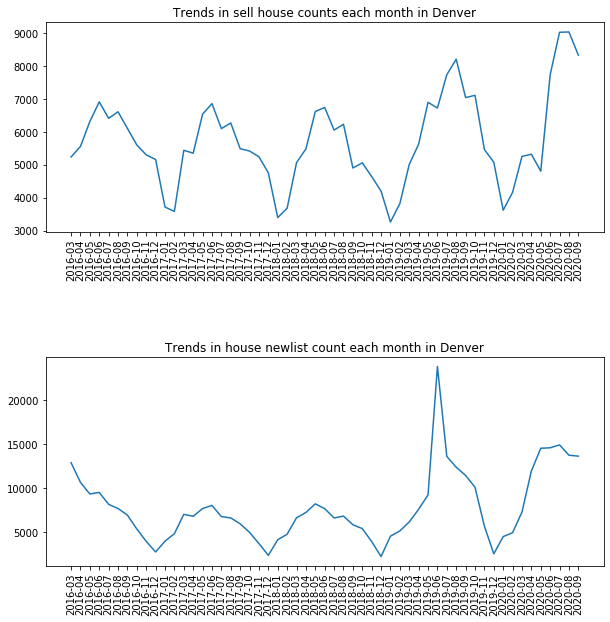

In [77]:
fig,ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(monthData.month,monthData['count_sale'])
ax[0].set_title('Trends in sell house counts each month in Denver')
ax[0].set_xticklabels(monthData['month'],rotation = 90)
ax[1].plot(monthData.month,monthData['count_list'])
ax[1].set_title('Trends in house newlist count each month in Denver')
ax[1].set_xticklabels(monthData['month'],rotation = 90)
plt.subplots_adjust(hspace=0.6)

If we try to predict the one order difference. Check the stationarity then.


In [78]:
result= adfuller(monthData['count_list'].diff(1).values[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.122070
p-value: 0.000013
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


In [79]:
result= adfuller(monthData['count_sale'].diff(1).values[1:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.170584
p-value: 0.217094
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


The p values are small, and the ADF statistics are smaller. Thus, the one order difference sequences for number of listing and number of sales are stationary.

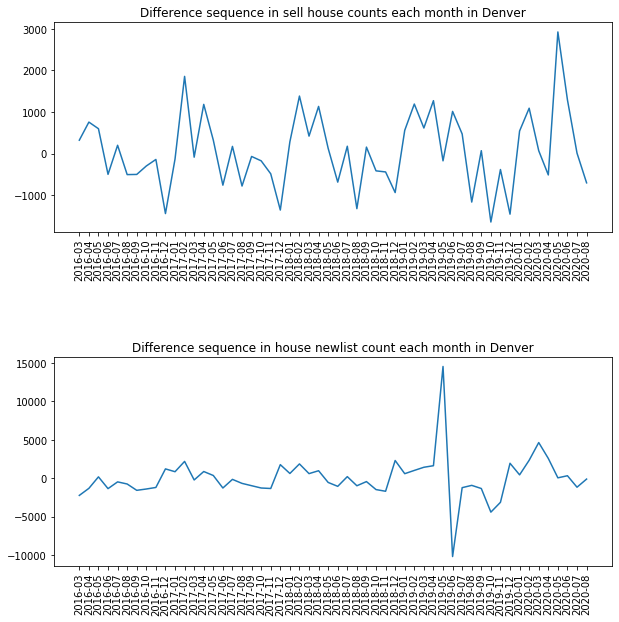

In [80]:
fig,ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(monthData['month'][1:],monthData['count_sale'].diff(1)[1:])
ax[0].set_title('Difference sequence in sell house counts each month in Denver')
ax[0].set_xticklabels(monthData['month'],rotation = 90)
ax[1].plot(monthData['month'][1:],monthData['count_list'].diff(1)[1:])
ax[1].set_title('Difference sequence in house newlist count each month in Denver')
ax[1].set_xticklabels(monthData['month'],rotation = 90)
plt.subplots_adjust(hspace=0.6)

Therefore, we will use the difference number between prediction month and current month as our final prediction in Google Trends model. That is, if we want to predict the number 3 months later, we will use the difference between the number in 3 months and the current number as our prediction.

### 1.2 Acquire averaged Google Trends data 

The number of google trends acquired by API is different in each time, that is because we can only get the partial data by google. Since the model is sensitive to the trends data, we acquire the google trends data for number of times(100 times), and use the average of it, to get a more stable data source.

In [6]:
Keywords_with_high_imrpessions = [
    ['homes for sale', 'homes for sale in', 'properties for sale','for sale home','homes for sales'], #home for sale
    ['townhomes for sale','townhouses for sale','townhouse for sale'], #townhomes for sale
    'Homes in', 
    'townhouses in',  
    'Homes near me', 
    'condominium for sale near me', 

    'zillow homes for sale',
                
    ['selling a house','sell home', 'selling your home'], #sell homes
     
    ['house appraisal','home appraisal'],#home appraisal
    
    ['home values', 'home valuations', 'home value', 'value of home'],#home values
    ['house valuations','house value', 'house valuation', 'value of house'],#house values
    'property value',
    'real estate values', 
    
    ['home value estimator','estimate property value'],  #home value estimator
     
    ['how much is my house','how much is my house worth',  'price my house', 'how much can i sell my house for'],  #how much is my house
    'home worth',
       
    ['house prices','house price', 'home prices', 'sold home prices'],#home price
                 
    ['rexhomes', 'rex real estate', 'rex home', 'rex house','rex homes'], #rex home
    ['zillow', 'zillow com','zillows'], #zillow.com
    ['real estate agents',  'listing agent'], #agents
    'best realtors',
    ['low commission real estate agents','low commission real estate'],   #low commission real estate
    'how to sell a house without a realtor',
    
                 
    ['for sale by owner', 'fsbo'], #for sale by owner
    'redfin', 
    'trulia', 
    'realtor.com',
    
    ['Homes in Denver', 'townhouses in Denver','houses in Denver'],#homes in denver
    ['selling a house in Denver','sell home in Denver', 'selling your home in Denver','homes for sale in Denver'],#Homes for sale in denver             
    ['house appraisal in Denver', 'home values in Denver', 'house price in Denver'],  #house appraisal in denver                
    'for sale by owner in Denver']

In [4]:
# set up google trends api
grouper = pd.Grouper(level='date', freq='M')
pytrends = TrendReq(hl='en-US', tz=360)
def get_keyword_to_time_series(keywords,geo='US-CO',return_columns = False):
    keyword_to_time_series = {}
    keywords_columns = []
    for keyword in keywords:
        time.sleep(10)
        if type(keyword) == list:
            pytrends.build_payload(keyword, cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
            pytrends_df = pytrends.interest_over_time()
            if len(pytrends_df)!=0: 
                pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
                time_series = np.mean(np.array(pytrends_monthly_df[keyword]),axis=1)
                keyword_to_time_series[keyword[0]] = time_series
                keywords_columns.append(keyword[0])
                #print(keyword)
        else:
            pytrends.build_payload([keyword], cat=0, timeframe='2016-03-01 2020-09-30', geo=geo)
            pytrends_df = pytrends.interest_over_time()
            if len(pytrends_df)!=0: 
                pytrends_monthly_df = pytrends_df.groupby(grouper)[keyword].mean().reset_index()
                time_series = np.array(pytrends_monthly_df[keyword])
                keyword_to_time_series[keyword] = time_series
                keywords_columns.append(keyword)
    if return_columns == True:
        return keyword_to_time_series, keywords_columns
    else:
        return keyword_to_time_series

In [80]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=300)

In [109]:
pytrends.build_payload(['sale'], cat=0, timeframe='2016-03-01 2020-09-30', geo='US-CO')
pytrends_df = pytrends.interest_over_time()

In [88]:
pytrends = TrendReq(hl='en-US', tz=360)

In [553]:
import time
keyword_to_time_series, keywords_columns = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO',return_columns=True)
for i in range(19):
    keyword_to_time_series_1 = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO')
    for keyword in keywords_columns:
        keyword_to_time_series[keyword] = keyword_to_time_series[keyword]+keyword_to_time_series_1[keyword]
    print(i+1)
    
    

1
2
3
4


ProxyError: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /trends/api/explore?hl=en-US&tz=360&req=%7B%22comparisonItem%22%3A+%5B%7B%22keyword%22%3A+%22trulia%22%2C+%22time%22%3A+%222016-03-01+2020-09-30%22%2C+%22geo%22%3A+%22US-CO%22%7D%5D%2C+%22category%22%3A+0%2C+%22property%22%3A+%22%22%7D (Caused by ProxyError('Cannot connect to proxy.', timeout('timed out')))

In [ ]:
keyword_to_time_series_1 = get_keyword_to_time_series(Keywords_with_high_imrpessions,geo='US-CO')

In [81]:
len(monthData.month)

55

In [52]:
trend = pd.DataFrame(keyword_to_time_series, index=monthData.month.values).reset_index()
trend

ValueError: Shape of passed values is (56, 28), indices imply (55, 28)

## 2. Stacking Time Series and Google Trends model

### 2.1 Evaluation metrics

One difficulty in evaluation models for Google Trends and time series model is that the target is a time series. We want to train the time series model by the history data, as well as evaluate the model performance and check the stationarity. Thus we use the nested cross validation mean squared error to evaluate models. 

![jupyter](nested_cross_validation.png)

In [200]:
def model_split(x, y, cv=5,return_idx = False, time_cv=None): #cv is the k-fold number
    time_periods = len(x)
    if time_cv ==None:
        time_cv = time_periods//cv #time periods length in a single training set
    elif time_cv!=time_periods//cv:
        cv = np.ceil(time_periods//time_cv)
    groups_train = {}
    groups_test = {}
    split_idx = []
    for i in range(cv-2):
        groups_train[i] = (x[:(i+1)*time_cv], y[:(i+1)*time_cv])
        groups_test[i] = (x[(i+1)*time_cv:(i+2)*time_cv], y[(i+1)*time_cv:(i+2)*time_cv])
        split_idx.append((i+1)*time_cv)
    groups_train[cv-2] = (x[:(cv-1)*time_cv], y[:(cv-1)*time_cv])
    groups_test[cv-2] = (x[(cv-1)*time_cv:], y[(cv-1)*time_cv:])
    split_idx.append((cv-1)*time_cv)
    if return_idx == False:
        return groups_train, groups_test
    else:
        return groups_train, groups_test, split_idx

def model_evaluation(model, groups_train, groups_test, cv):
    scores = []
    preds = []
    for i in range(cv-1):
        model_copy = model
        #print(len(groups_train), time_cv)
        print('train time : ', i+1)
        #print(groups_train[i][0])
        model_copy.fit(groups_train[i][0], groups_train[i][1])
        pred = model_copy.predict(groups_test[i][0])
        mse = mean_squared_error(groups_test[i][1], pred)
        scores.append(mse)
        print(mse)
        preds.extend(list(pred))
    
    return preds, scores


def nested_cv_evaluation(model,x,y,cv=5):
    groups_train, groups_test = model_split(x,y,cv)
    preds, scores = model_evaluation(model,groups_train, groups_test, cv)
    return preds, scores


### 2.2 Rolling Training

In [131]:
import tensorflow.compat.v2 as tf
from tensorflow_probability import sts
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [512]:
#Step 1:  evaluate the time series model
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

def build_variational_posteriors(model, training_data, nsamples,
                                 optimizer = tf.optimizers.Adam(learning_rate=.05),
                                 plot = True
                                ):
    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)
    # Using fit_surrogate_posterior to build and optimize the variational loss function.
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    if plot:
        plt.plot(elbo_loss_curve)
        plt.title("ELBO loss curve")
        plt.show()

    # Draw samples from the variational posterior.
    q_samples = variational_posteriors.sample(nsamples)
    
    return q_samples

class BTSM(object):
    def __init__(self,):
        self.model = 0
        self.q_samples = 0
        
    def fit(self,x_train, y_train):
        self.train = x_train
        self.model = build_model(x_train)
        self.q_samples = build_variational_posteriors(self.model, x_train,len(x_train),
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = False)
        
        
    def predict(self,x_test,num_samples=100):
        forecast_dist = tfp.sts.forecast(self.model, observed_time_series=self.train,
                                            parameter_samples=self.q_samples, num_steps_forecast=len(x_test))

        forecast_mean, forecast_scale, forecast_samples = (forecast_dist.mean().numpy()[..., 0],
                                                           forecast_dist.stddev().numpy()[..., 0],
                                                           forecast_dist.sample(num_samples).numpy()[..., 0])
        return forecast_mean
        


In [513]:
sales = monthData['count_sale'].values.astype(float)
lists = monthData['count_list'].values.astype(float)
bmodel = BTSM()
bmodel.fit(sales,0)
pred_sales = bmodel.predict(np.ones(6))


In [514]:
bmodel = BTSM()
preds,scores = nested_cv_evaluation(bmodel,sales,sales,cv=9)

train time :  1
8764421.730315119
train time :  2
5650013.43931545
train time :  3
56430.92672288004
train time :  4
43066.08436514023
train time :  5
219244.59254219718
train time :  6
942162.167720717
train time :  7
4773891.826156495
train time :  8
2584119.4685808877


In [515]:
groups_train, groups_test, split_idx = model_split(sales, sales, cv=9, return_idx=True)
split_idx

[6, 12, 18, 24, 30, 36, 42, 48]

The net cross validation mse score is:  1712496.8278730877


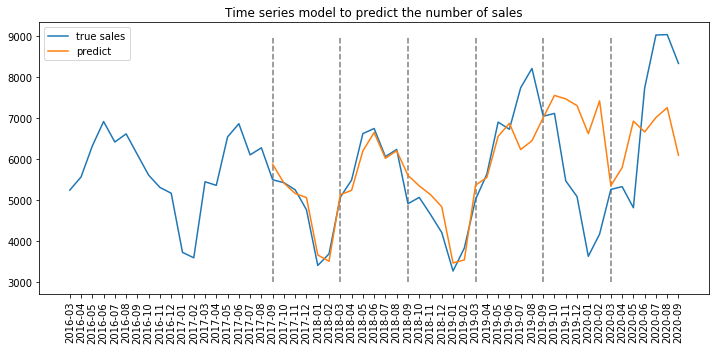

In [516]:
print('The net cross validation mse score is: ', np.mean(scores[3:]))
plt.figure(figsize=(12,5))
plt.plot(monthData.month, list(sales),label ='true sales')
plt.plot(monthData.month[18:], preds[12:],label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=9000,alpha=0.5,linestyle='--')
plt.title('Time series model to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [517]:
bmodel1 = BTSM()
preds1,scores1 = nested_cv_evaluation(bmodel1,lists,lists,cv=9)

train time :  1
1825608.095241349
train time :  2
48469044.69719706
train time :  3
360550.13590409374
train time :  4
1061859.5562363404
train time :  5
204016.06020977898
train time :  6
57677608.33473608
train time :  7
63573374.837060414
train time :  8
22461217.515571915


The net cross validation mse score is:  28995615.260762908


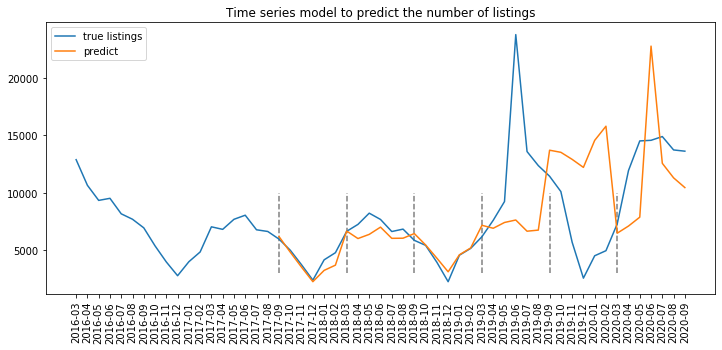

In [518]:
print('The net cross validation mse score is: ', np.mean(scores1[3:]))
plt.figure(figsize=(12,5))
plt.plot(monthData.month, list(lists),label ='true listings')
plt.plot(monthData.month[18:], preds1[12:],label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Time series model to predict the number of listings')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [519]:
#Step 2: evaluate the google trends model
trend = pd.read_csv('google_trends.csv')
merged = pd.merge(monthData, trend, left_on ='month', right_on='index').drop(['index','Unnamed: 0_x','Unnamed: 0_y'],axis=1)
#merged.columns

In [520]:
#predictors: current, lag1, lag3 for google trends, current, lag1, lag3 of count of sales/listings, month of a year t
feature_column_names = merged.columns.delete(1)
f = merged.columns.delete(1)
for i, col in enumerate(f):
    #print(col)
    merged[col+'_lag1'] = merged[col].diff(1)
    merged[col+'_lag2'] = merged[col].diff(2)
    feature_column_names = np.append(feature_column_names,str(col)+'_lag1')
    feature_column_names = np.append(feature_column_names,str(col)+'_lag2')
merged['t'] = merged['month'].apply(lambda x: str(x[-2:])+'m')
one_hot_month = pd.get_dummies(merged['t'])
feature_column_names = np.append(feature_column_names,one_hot_month.columns)
merged = merged.join(one_hot_month)

In [521]:
class PCA_KNN_model(object):
    def __init__(self,n_neighbors=2):
        self.model = np.nan
        self.n_neighbors = n_neighbors
    def fit(self,x_train,y_train):
        self.model = KNeighborsRegressor(n_neighbors=self.n_neighbors)
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        self.pca = PCA(n_components=4)
        x_train_pca = self.pca.fit_transform(x_train_std)
        self.model.fit(x_train_pca, y_train)
    def predict(self,x_test):
        #print(x_test)
        x_test_std = self.std.transform(x_test)
        x_test_pca = self.pca.transform(x_test_std)
        return self.model.predict(x_test_pca)

In [522]:
class PCA_KNN_rolling_model(object):
    def __init__(self,n_neighbors=2,predict_horizon=6,start_fit=2):
        self.models = {}
        self.n_neighbors = n_neighbors
        self.predict_horizon = predict_horizon
        self.start_fit = start_fit
    def fit(self,x_train,y_train):
        for i in range(1,self.predict_horizon+1):
            self.x_train = x_train
            self.y_train = y_train
            self.models[i] = PCA_KNN_model(self.n_neighbors)
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].fit(x,y)
    def predict(self):
        y_pred = []
        for i in range(1,self.predict_horizon+1):
            pred_temp = self.models[i].predict(self.x_train[-2:])
            y_pred.append(pred_temp[-1]+self.y_train.iloc[-1])
        return y_pred

In [523]:
prediction_col = 'count_sale'
groups_train, groups_test, split_idx= model_split(merged[feature_column_names],merged[prediction_col],cv=9,return_idx=True)
split_idx


[6, 12, 18, 24, 30, 36, 42, 48]

In [524]:
pred_google_store = []
for i in range(6):
    #print(i)
    m = PCA_KNN_rolling_model()
    x = groups_train[i+2][0]
    y = groups_train[i+2][1]
    m.fit(x,y) 
    pred_google = m.predict()
    pred_google_store.extend(pred_google)

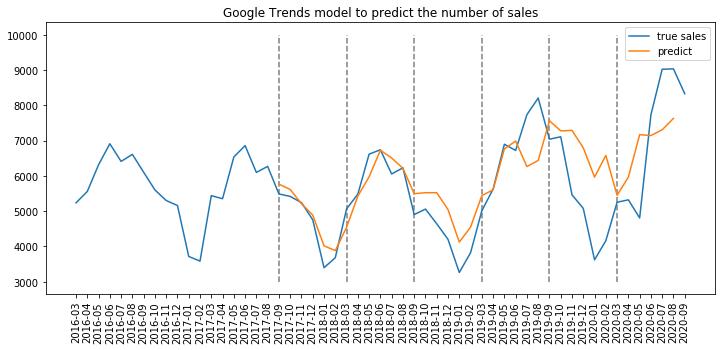

In [525]:
plt.figure(figsize=(12,5))
plt.plot(monthData.month, sales,label ='true sales')
plt.plot(monthData.month[18:-1], pred_google_store,label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google Trends model to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months

In [502]:
class Lasso_Tree_model(object):
    def __init__(self,params=None):
        self.model = np.nan
        self.selected_features_list_no = np.nan
        
    def train_params(self,x_train,y_train):
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        lr = Lasso(alpha=700)
        lr.fit(x_train_std,y_train)
        self.selected_features_list_no = abs(lr.coef_)>0
    def fit(self,x_train,y_train):
        self.std = StandardScaler()
        x_train_std = self.std.fit_transform(x_train)
        #self.selected_features_list = feature_column_names[abs(lr.coef_)>0]
        print(sum(self.selected_features_list_no))
        self.model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=3)
        self.model.fit(x_train_std[:,self.selected_features_list_no], y_train)
    def predict(self,x_test):
        #print(x_test)
        x_test_std = self.std.transform(x_test)
        return self.model.predict(x_test_std[:,self.selected_features_list_no])

In [503]:
class Lasso_Tree_rolling_model(object):
    def __init__(self,predict_horizon=6,start_fit=2, params=None):
        self.models = {}
        self.predict_horizon = predict_horizon
        self.start_fit = start_fit
    def train_params(self,x_train, y_train):
        for i in range(1,self.predict_horizon+1):
            self.models[i] = Lasso_Tree_model()
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].train_params(x,y)
    def fit(self,x_train,y_train):
        self.x_train = x_train
        self.y_train = y_train
        for i in range(1,self.predict_horizon+1):
            y = y_train.diff(i).shift(-i)[self.start_fit:-i]
            x = x_train[self.start_fit:-i]
            self.models[i].fit(x,y)
    def predict(self):
        y_pred = []
        for i in range(1,self.predict_horizon+1):
            pred_temp = self.models[i].predict(self.x_train[-2:])
            y_pred.append(pred_temp[-1]+self.y_train.iloc[-1])
        return y_pred

In [504]:
prediction_col = 'count_list'
groups_train, groups_test, split_idx= model_split(merged[feature_column_names],merged[prediction_col],cv=9,return_idx=True)
split_idx

[6, 12, 18, 24, 30, 36, 42, 48]

In [505]:
pred_google_store1 = []
for i in range(6):
    m = Lasso_Tree_rolling_model()
    m.train_params(merged[feature_column_names], merged[prediction_col])
    m.fit(groups_train[i+2][0],groups_train[i+2][1])
    pred_google =  m.predict()
    pred_google_store1.extend(pred_google)

5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6
5
10
13
12
11
6


In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthData.month, lists,label ='true listings')
plt.plot(monthData.month[18:-1], pred_google_store1,label='predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=20000,alpha=0.5,linestyle='--')
plt.title('Google Trends model to predict the number of listings')
plt.xticks(rotation=90)
plt.legend()

### 2.2 Stacking methods

The stacking agorithm will also take in the nested cross validation idea. This time, the rolling training and prediction will be conduct, and we will receive a series of rolling-trained out-sample predictions for both Time Series and Googel Trends model. Then we will build another model, based on the predictions in two models, and the target. To avoid overfitting, we will use a relatively simple model (like linear), to combine the two models. 

In [548]:
#linear combination
x2 = pred_google_store
x1 = preds[12:-1]
y = sales[18:-1]
lr = LinearRegression()
lr.fit(np.concatenate([[x1],[x2]]).T, y)
print(lr.coef_)
print(lr.intercept_)
lr.score(np.concatenate([[x1],[x2]]).T, y)

[-0.72441396  1.83355623]
-1018.677047006111


0.5735821908863574

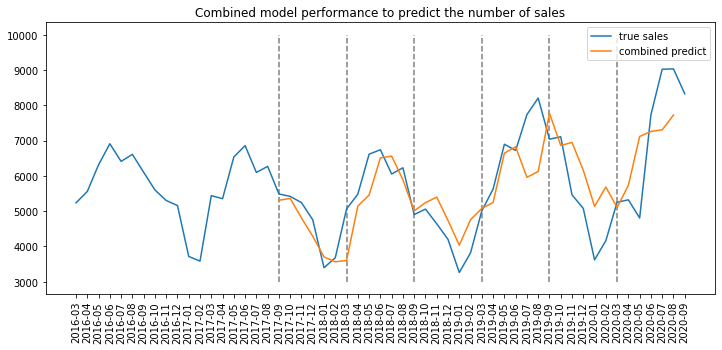

In [552]:
#final prediction
prediction = -0.72*np.array(x1) + 1.83*np.array(x2)-1018.67
plt.figure(figsize=(12,5))
plt.plot(monthData.month, sales,label ='true sales')
plt.plot(monthData.month[18:-1], prediction,label='combined predict')
plt.vlines(np.array(split_idx[2:]),ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
#plt.plot(monthData.month[18:-1], x2,label='google trends predict', linestyle ='--')
#plt.plot(monthData.month[18:-1], x1,label='time series predict', linestyle ='--')
plt.title('Combined model performance to predict the number of sales')
plt.xticks(rotation=90)
plt.legend()
#evaluate the model after 18 months


In [549]:
#mse calculation
print('The mse in time series model :', mean_squared_error(y,x1))
print('The mse in google trends model :', mean_squared_error(y,x2))
print('The mse in combined model :', mean_squared_error(y,-0.72*np.array(x1) + 1.83*np.array(x2)-1018.67))


The mse in time series model : 1368917.7202674372
The mse in google trends model : 1098094.2847222222
The mse in combined model : 934142.3082617968


## Next step
- Update google trends data and models
- Winsorize? (number of listing)
- confident interval 